# Libraries

In [3]:
import os
import glob
import math
import gc
from typing import Any, Dict, List
from dataclasses import dataclass

from collections import defaultdict

from src.pipeline.dataloader import DataLoader, DataLoaderConfig
from src.pipeline.frame.filter import FrameFilters
from src.pipeline.frame.transformer import FrameTransformers
from src.pipeline.taskloader import TaskLoader, TaskFrame, TaskLoaderConfig
from src.pipeline.trainer import Trainer

from src.utils.parsers.cv_parser import to_cv_params, parse_cv_result, fmt_cv_results, _fmt_regressor
from src.utils.utils import TestResultStore

from src.settings.strategy import Strategy
from src.settings.tier import Tier

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from scipy.stats import pearsonr

from lime import lime_tabular
import shap

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, GammaRegressor

from sklearn.metrics import mean_absolute_error

/home/tvangraft/tudelft/thesis/.env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
DataLoader.DATA_FOLDER = './data/training/'
dl = DataLoader()
tl = TaskLoader()

GRIDSEARCH_KWARGS = dict(
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    refit=True,
    verbose=1,
    error_score='raise',
)

shap.initjs()

# Model building

In [5]:
def get_generator(
    strategy:Strategy=Strategy.METABOLITE_CENTRIC,
    tier=Tier.TIER1,
    data_config: DataLoaderConfig = DataLoaderConfig(),
    task_config: TaskLoaderConfig = TaskLoaderConfig()
):
    df = dl.get_dataframe(data_config)
    gen = tl.prepare_task(df, tier).build(strategy, task_config)
    return gen

def build_model_pipeline(
    strategy:Strategy=Strategy.METABOLITE_CENTRIC,
    tier=Tier.TIER1
):
    tf = next(get_generator(
        strategy, tier
    ))
    
    numeric_features = ['enzyme_concentration'] + tf.x.columns.to_list()
    numeric_features = list(filter(lambda x: x in tf.x.columns.to_list(), numeric_features))
    numeric_transformer = Pipeline(
        steps=[
            ('scaler', StandardScaler())
        ]
    )

    cat_features = ['KO_ORF', 'ORF']
    cat_features = list(filter(lambda x: x in tf.x.index.names, cat_features))

    categorical_transformer = OneHotEncoder(
        categories=[
            y[cat].unique() for cat in cat_features if (y := tf.x.reset_index()) is not None
            # tf.x.reset_index()['KO_ORF'].unique(),
            # tf.x.reset_index()['ORF'].unique()
        ]
    )

    prepocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            # ('cat', categorical_transformer, cat_features),
        ],
        remainder='drop'
    )

    estimator = DecisionTreeRegressor()

    clf = Pipeline(
        steps=[
            ('preprocessor', prepocessor),
            # ('pca', PCA()),
            ('regressor', estimator),
        ]
    )

    model = TransformedTargetRegressor(
        regressor=clf,
        transformer=None,
    )
    return model



## Base data model (Tier 0)

In [6]:
EXPERIMENT_ID = 'experiment_0'
PATH_PREFIX = './data/results'
EXPERIMENT_PATH = f'{PATH_PREFIX}/{EXPERIMENT_ID}'
TIER = Tier.TIER0

if not os.path.exists(f'{EXPERIMENT_PATH}'):
    os.makedirs(f'{EXPERIMENT_PATH}')

config = DataLoaderConfig(
    additional_filters=[dl.data_factory.filters.is_precursor],
    additional_transforms=[dl.data_factory.transformer.log_fold_change_protein]
)

cv = RepeatedKFold(n_repeats=1, n_splits=10, random_state=0)

In [7]:
params = {
    'SVR': {
        'regressor__regressor': SVR(),
        'regressor__regressor__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        #'regressor__pca__n_components': [0.1, 0.25, 0.5, 0.75, 0.99],
        'regressor__preprocessor__num__scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()],
    },
    'DecisionTreeRegressor': {
        'regressor__regressor': DecisionTreeRegressor(),
        'regressor__regressor__criterion': ['squared_error', 'friedman_mse'],
        'regressor__regressor__max_depth': [5, 10, 20, 15],
        #'regressor__pca__n_components': [0.1, 0.25, 0.5, 0.75, 0.99],
        'regressor__preprocessor__num__scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()]
    },
    # 'GammaRegressor': {
    #     'regressor__regressor': GammaRegressor(),
    #     'regressor__regressor__alpha': [0, 1, 10],
    #     'regressor__pca__n_components': [0.1, 0.25, 0.5, 0.75, 0.99],
    #     'regressor__preprocessor__num__scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()],
    # },
    'ElasticNet': {
        'regressor__regressor': ElasticNet(),
        'regressor__regressor__l1_ratio': [0.01, 0.25, 0.5, 0.75, 1],
        'regressor__regressor__tol': [0.01],
        #'regressor__pca__n_components': [0.1, 0.25, 0.5, 0.75, 0.99],
        'regressor__preprocessor__num__scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()]
    }
}

### Strategy All

In [25]:
STRATEGY = Strategy.ALL
SPLIT_KWARGS=dict(
    stratify='metabolite_id',
    shuffle=True
)
trainer = Trainer()

#### Learning

In [26]:
model = build_model_pipeline(tier=TIER)
gen = get_generator(
    strategy=STRATEGY,
    tier=TIER,
    data_config=config
)
tf: TaskFrame = next(gen)

DataLoaderConfig(additional_frames=[], additional_transforms=[], additional_filters=[])
DataLoaderConfig(additional_frames=[], additional_transforms=[<bound method FrameTransformers.log_fold_change_protein of <src.pipeline.frame.transformer.FrameTransformers object at 0x7f2a01f87bb0>>], additional_filters=[<bound method FrameFilters.is_precursor of <src.pipeline.frame.filter.FrameFilters object at 0x7f2a01f87850>>])


In [7]:
search = trainer.do_grid_search(
    tf,
    model, 
    params,
    cv,
    split_kwargs=SPLIT_KWARGS,
    search_kwargs=GRIDSEARCH_KWARGS,
)

pd.DataFrame(search.cv_results_).to_csv(f'{EXPERIMENT_PATH}/{tf.title}_{tf.frame_name}.csv')

Training: Strategy.ALL_all.csv
tf.x.shape=(737, 726) (737,)
{'scoring': 'neg_mean_absolute_error', 'n_jobs': -1, 'refit': True, 'verbose': 1, 'error_score': 'raise'}
Fitting 10 folds for each of 51 candidates, totalling 510 fits


In [ ]:
results_df = pd.read_csv(f'{EXPERIMENT_PATH}/Strategy.ALL_all.csv')
results_df = _fmt_regressor(results_df)
architectures = ['all'] + results_df['param_regressor__regressor'].unique().tolist()
results_df.columns

In [27]:
results_df = pd.read_csv(f'{EXPERIMENT_PATH}/Strategy.ALL_all.csv')
results_df = _fmt_regressor(results_df)
architectures = ['all'] + results_df['param_regressor__regressor'].unique().tolist()
testResultStore = TestResultStore(EXPERIMENT_PATH, STRATEGY)

for architecture in architectures:
    _result_df = results_df.copy() if architecture == 'all' else results_df[results_df['param_regressor__regressor'] == architecture].copy()
    _result_df = _result_df.sort_values('rank_test_score').iloc[[0]]
    print(architecture)

    model = build_model_pipeline(tier=Tier.TIER0)
    model = parse_cv_result(model, _result_df)
    model = trainer.do_retrain_model(tf, model, split_kwargs=SPLIT_KWARGS)

    _, X_test, _, y_test = trainer.do_train_test_split(tf, **SPLIT_KWARGS)

    testResultStore.update_results(
        'all', model, architecture,
        X_test, y_test
    )

    for metabolite_id in X_test['metabolite_id'].unique():
        testResultStore.update_results(
            metabolite_id, 
            model,
            architecture,
            X_test[X_test['metabolite_id'] == metabolite_id], 
            y_test.xs(metabolite_id, level='metabolite_id')
        )

testResultStore.to_file()

all
DataLoaderConfig(additional_frames=[], additional_transforms=[], additional_filters=[])
DecisionRegressor model
SVR()
DataLoaderConfig(additional_frames=[], additional_transforms=[], additional_filters=[])
SVR model
DecisionTreeRegressor()
DataLoaderConfig(additional_frames=[], additional_transforms=[], additional_filters=[])
DecisionRegressor model
ElasticNet()
DataLoaderConfig(additional_frames=[], additional_transforms=[], additional_filters=[])
ElasticNet model


#### Data throttle experiment

In [ ]:
for i in range(10, 110, 10):
    task_config = TaskLoaderConfig(data_throttle=i/100)

    model = build_model_pipeline(tier=TIER)
    gen = get_generator(
        strategy=STRATEGY,
        tier=TIER,
        data_config=config,
        task_config=task_config,
    )
    tf: TaskFrame = next(gen)

    search = trainer.do_grid_search(
        tf,
        model, 
        params,
        cv,
        split_kwargs=SPLIT_KWARGS
    )

    if not os.path.exists(f'{EXPERIMENT_PATH}/throttle/'):
        os.makedirs(f'{EXPERIMENT_PATH}/throttle')

    pd.DataFrame(search.cv_results_).to_csv(f'{EXPERIMENT_PATH}/throttle/{tf.title}_{tf.frame_name}_throttle{i/100}.csv')

In [ ]:
for i in range(10, 110, 10):
    gc.collect()
    for j in range(100):
        if not os.path.exists(EXPERIMENT_PATH + '/throttle/' + f"best_model_prediction_performance_{STRATEGY}_throttle{i/100}__run{j}.json"):
            # best_model_prediction_performance_Strategy.ALL_throttle0.2__run70
            print(f"{EXPERIMENT_PATH}/throttle/best_model_prediction_performance_{STRATEGY}_throttle{i/100}__run{j}.json")
            print(f"throttle: {i}  run: {j}")
            results_df = pd.read_csv(f'{EXPERIMENT_PATH}/throttle/Strategy.ALL_all_throttle{i/100}.csv')
            task_config = TaskLoaderConfig(data_throttle=i/100)

            gen = get_generator(
                strategy=STRATEGY,
                tier=TIER,
                data_config=config,
                task_config=task_config,
            )
            tf: TaskFrame = next(gen)

            model = build_model_pipeline(tier=TIER)
            model = parse_cv_result(model, results_df[results_df['rank_test_score'] == 1])
            model = trainer.do_retrain_model(tf, model, split_kwargs=SPLIT_KWARGS)

            _, X_test, _, y_test = trainer.do_train_test_split(tf, **SPLIT_KWARGS)
            print(X_test.shape)

            testResultStore = TestResultStore(EXPERIMENT_PATH + '/throttle/', f"{STRATEGY}_throttle{i/100}__run{j}")
            testResultStore.update_results(
                'all', model,
                X_test, y_test
            )

            for metabolite_id in X_test['metabolite_id'].unique():
                testResultStore.update_results(
                    metabolite_id, 
                    model,
                    X_test[X_test['metabolite_id'] == metabolite_id], 
                    y_test.xs(metabolite_id, level='metabolite_id')
                )

            testResultStore.to_file()

#### Explanation

In [72]:
gen = get_generator(
    strategy=STRATEGY,
    tier=TIER,
    data_config=config
)
tf: TaskFrame = next(gen)
results_df = pd.read_csv(f'{EXPERIMENT_PATH}/Strategy.ALL_all.csv')

model = build_model_pipeline(tier=TIER)
model = parse_cv_result(model, results_df[results_df['rank_test_score'] == 1])
model = trainer.do_retrain_model(tf, model, split_kwargs=SPLIT_KWARGS)

X_train, X_test, y_train, y_test = trainer.do_train_test_split(tf, **SPLIT_KWARGS)

selected_feature_names = np.vectorize(lambda x: x.removeprefix("num__"))(model.regressor_[:-1].get_feature_names_out())

DataLoaderConfig(additional_frames=[], additional_transforms=[<bound method FrameTransformers.log_fold_change_protein of <src.pipeline.frame.transformer.FrameTransformers object at 0x7f8b5708ba60>>], additional_filters=[<bound method FrameFilters.is_precursor of <src.pipeline.frame.filter.FrameFilters object at 0x7f8b5708b460>>])
DataLoaderConfig(additional_frames=[], additional_transforms=[], additional_filters=[])
DecisionRegressor model


In [73]:
def apply_transform(X):
    _X = X
    for step in model.regressor_.steps[:-1]:
        _X = step[1].transform(_X)
    return _X

def apply_predict(X):
    return model.regressor_.named_steps['regressor'].predict(X)

def predict(x: np.array):
    _x = pd.DataFrame(
        np.append(np.zeros(shape=(x.shape[0], 2)), x, axis=1),
        columns=X_train.columns
    )
    return model.predict(_x)

In [ ]:
explanation_result = defaultdict(list)

_X_train = X_train[X_train.columns.difference(['KO_ORF', 'metabolite_id'])]
_X_test = X_test[X_test.columns.difference(['KO_ORF', 'metabolite_id'])]

explainer = lime_tabular.LimeTabularExplainer(
    _X_train.values, 
    feature_names=_X_train.columns, 
    verbose=True, 
    mode='regression',
    discretize_continuous=False
)

for i in range(len(X_test)):
    exp = explainer.explain_instance(_X_test.iloc[i], predict, num_features=10)
    explanation_result['KO_ORF'].append(X_test.iloc[i]['KO_ORF'])
    explanation_result['metabolite_id'].append(X_test.iloc[i]['metabolite_id'])
    explanation_result['exp_enzymes'].append([enzyme for enzyme, _ in exp.as_list()])
    explanation_result['exp_weights'].append([weight for _, weight in exp.as_list()])
    explanation_result['y_true'].append(exp.predicted_value)
    explanation_result['y_pred'].append(y_test.iloc[i])

pd.DataFrame.from_dict(explanation_result).to_json(f"{EXPERIMENT_PATH}/explanations/{STRATEGY}_explanation.json")



In [75]:
i = 2
exp = explainer.explain_instance(_X_test.iloc[i], predict, num_features=10)
print(y_test.iloc[i])
print(exp.as_list())
exp.show_in_notebook(show_table=True)

Intercept 0.385447485646703
Prediction_local [0.35080088]
Right: 0.9257655351971584
1.346157786681026
[('YDL014W', -0.18000944074939942), ('YCR012W', 0.10087386105691565), ('YHR190W', -0.08089203802104139), ('YLR175W', 0.03546950706863226), ('YOR298C-A', -0.026299694533891874), ('YER094C', 0.01946210123826317), ('YDR188W', 0.016373486181457814), ('YJL217W', 0.013421498118574333), ('YJL172W', -0.010905257909092516), ('YBR263W', -0.007090738679347527)]


In [76]:
X_train_summary = shap.kmeans(apply_transform(X_train), 12)
ex = shap.KernelExplainer(apply_predict, X_train_summary)

In [77]:
sv_one_instance = ex.shap_values(apply_transform(X_test.iloc[0,:].to_frame().T))
shap.force_plot(ex.expected_value, sv_one_instance, apply_transform(X_test.iloc[0,:].to_frame().T), feature_names=selected_feature_names)

  0%|          | 0/1 [00:00<?, ?it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
100%|██████████| 1/1 [00:03<00:00,  3.03s/it]


In [ ]:
idx = 0
sv = ex.shap_values(apply_transform(X_test), gc_collect=True)
exp = shap.Explanation(sv, np.array([ex.expected_value] * 222), data=apply_transform(X_test), feature_names=selected_feature_names)

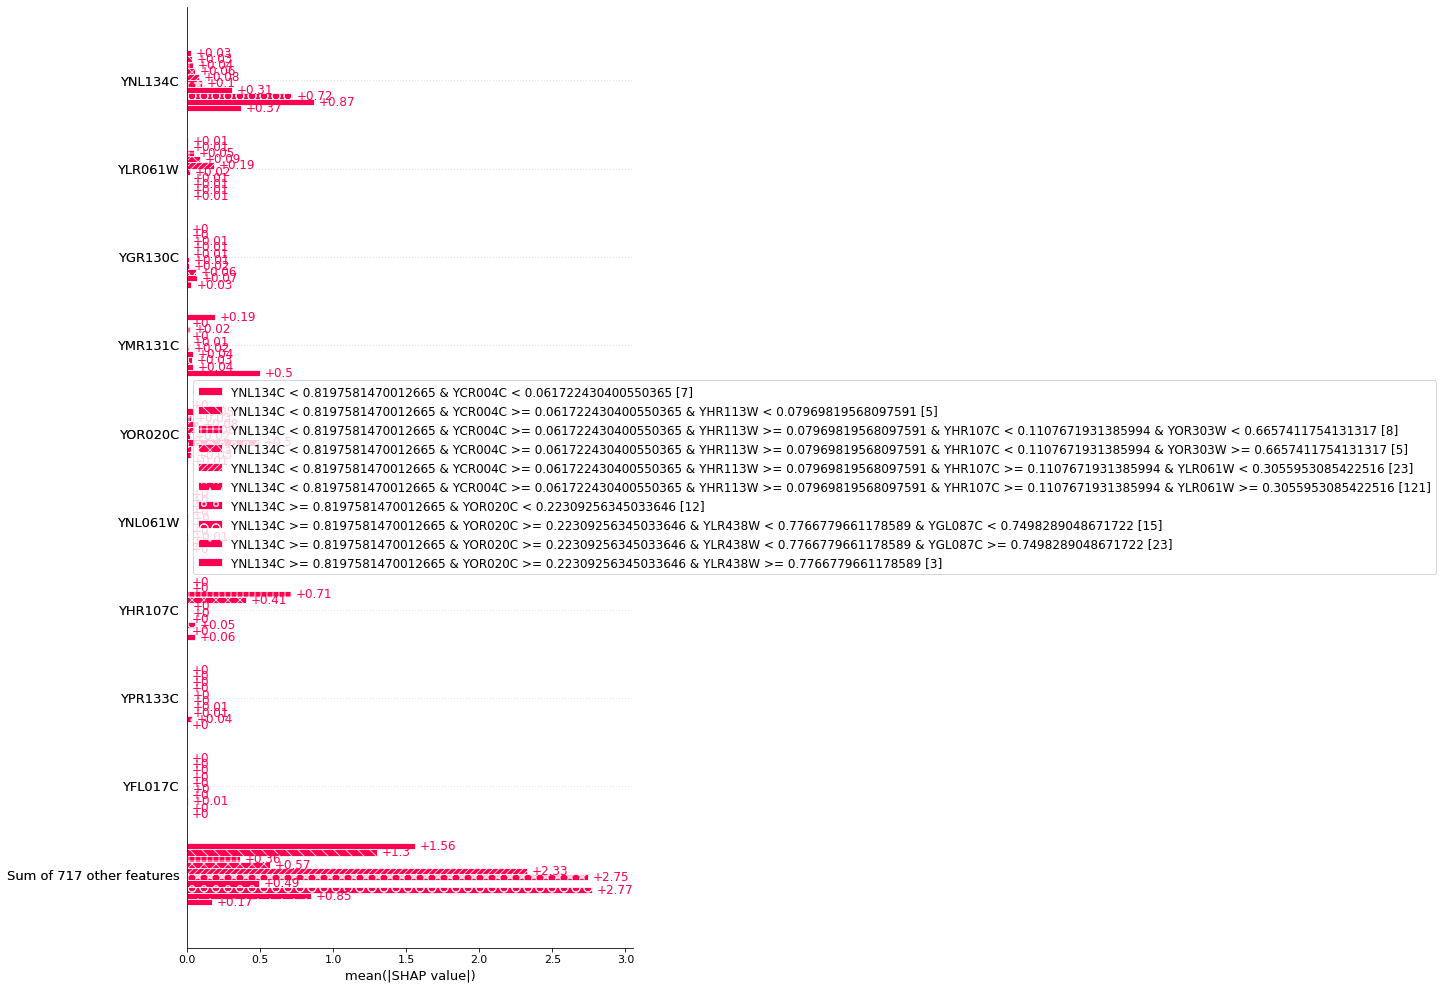

In [65]:
shap.plots.bar(exp.cohorts(10).abs.mean(0))

In [ ]:
clustering = shap.utils.hclust(apply_transform(X_test), y_test) # by default this trains (X.shape[1] choose 2) 2-feature XGBoost models
shap.plots.bar(exp, clustering=clustering)

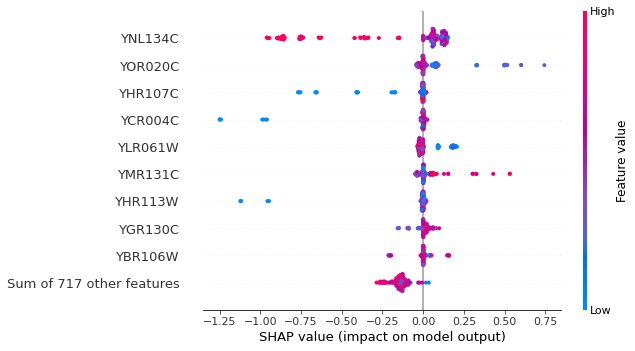

In [60]:
shap.plots.beeswarm(exp, show=False)
plt.savefig('./images/explanation_beeswarm_all_metabolites.svg')
plt.savefig('./images/explanation_beeswarm_all_metabolites.png')

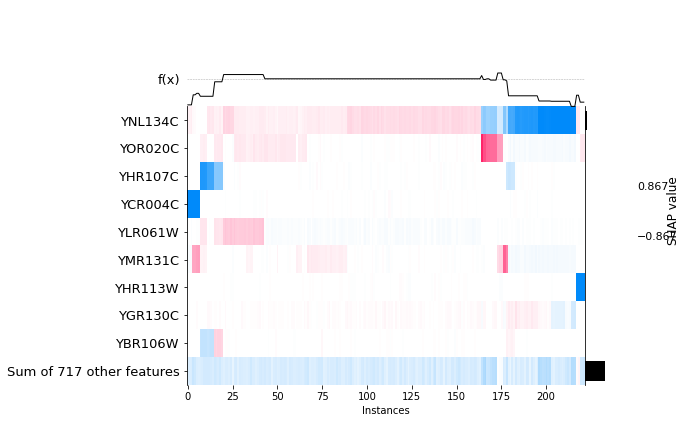

<Figure size 432x288 with 0 Axes>

In [52]:
shap.plots.heatmap(exp, max_display=10)
plt.savefig('./images/explanation_heatmap_all_metabolites.svg')

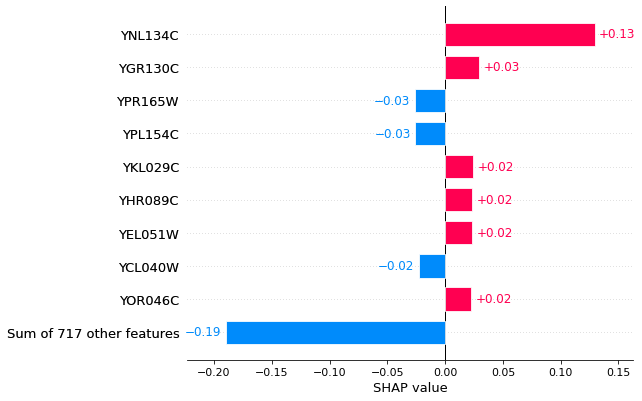

In [53]:
shap.plots.bar(exp[0])

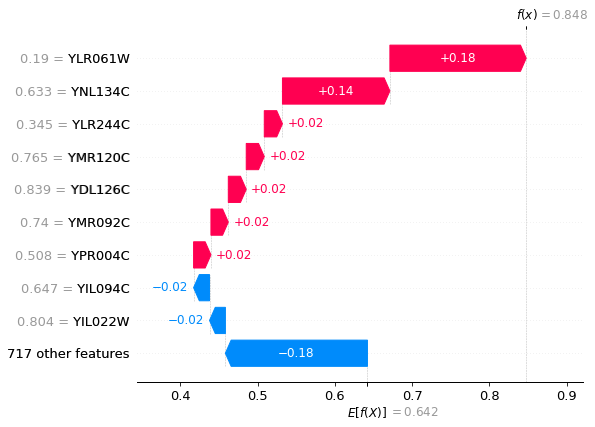

In [56]:
shap.plots.waterfall(exp[1])

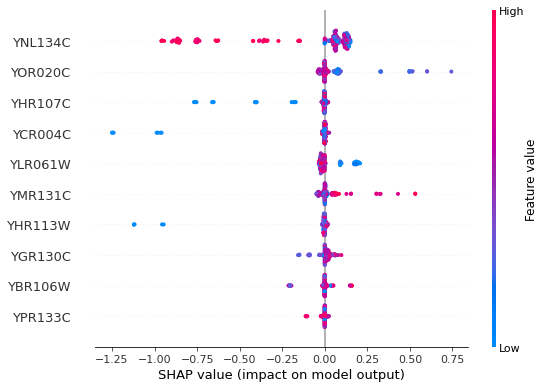

In [59]:
shap.summary_plot(sv, apply_transform(X_test), feature_names=selected_feature_names, max_display=10)


FixedFormatter should only be used together with FixedLocator


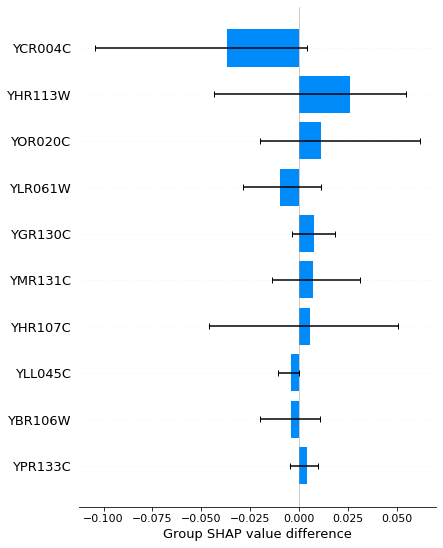

In [57]:
shap.plots.group_difference(
    sv,
    (X_test['metabolite_id']=='pyr').to_numpy(),
    feature_names=selected_feature_names,
    max_display=10
)

FixedFormatter should only be used together with FixedLocator


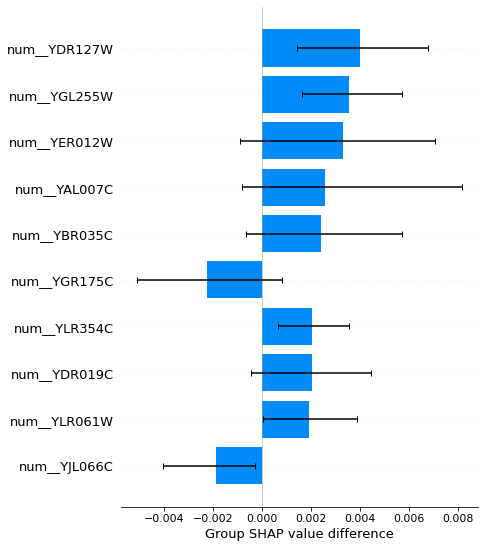

In [19]:
shap.group_difference_plot(
    sv,
    (X_test['metabolite_id']=='pyr').to_numpy(),
    feature_names=selected_feature_names,
    max_display=10
)

  0%|          | 0/29 [00:00<?, ?it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  3%|▎         | 1/29 [00:02<01:05,  2.34s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(

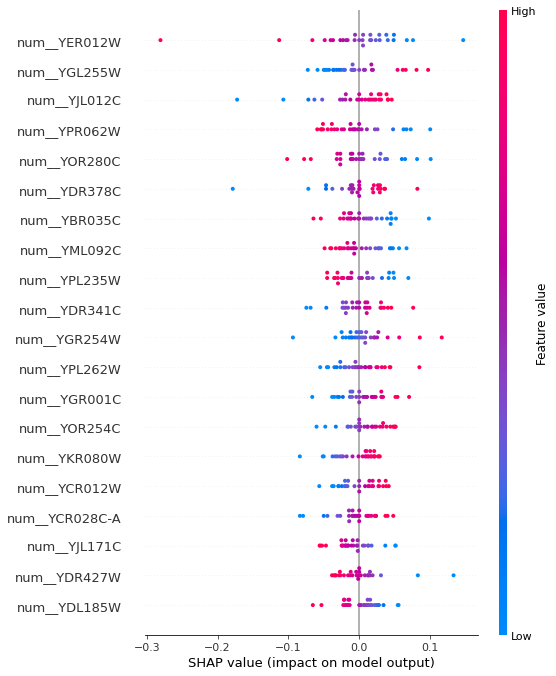

  0%|          | 0/29 [00:00<?, ?it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  3%|▎         | 1/29 [00:02<01:02,  2.23s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(

KeyboardInterrupt: 

In [36]:
for metabolite_id in X_test['metabolite_id'].unique():
    _X_test = X_test[X_test['metabolite_id'] == metabolite_id]
    shap_values = ex.shap_values(apply_transform(_X_test), gc_collect=True)
    shap.summary_plot(shap_values, apply_transform(_X_test), feature_names=selected_feature_names)
    


In [ ]:
shap_values = ex.shap_values(apply_transform(X_test))

In [51]:
shap.waterfall_plot(shap_values)

AttributeError: 'numpy.ndarray' object has no attribute 'base_values'

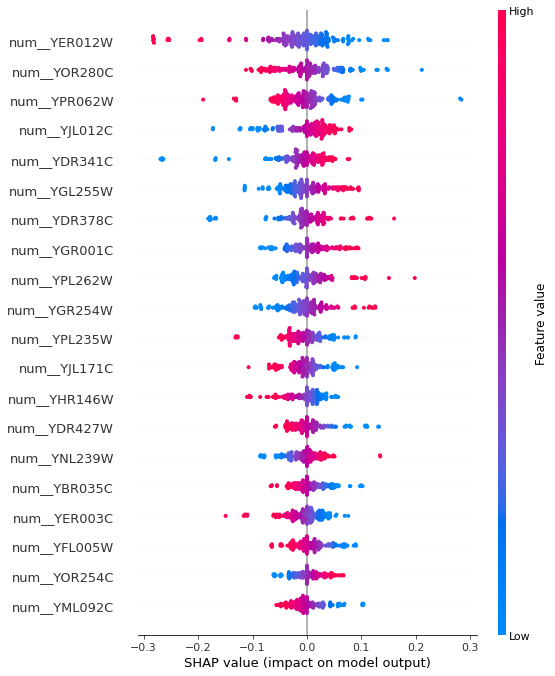

In [16]:
shap.summary_plot(shap_values, apply_transform(X_test), feature_names=selected_feature_names)

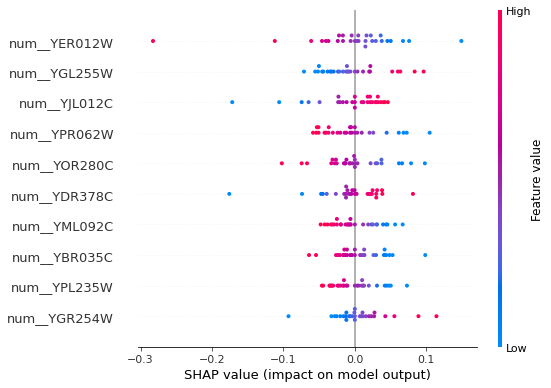

In [35]:
shap.summary_plot(shap_values, apply_transform(_X_test), feature_names=selected_feature_names, max_display=10)

In [ ]:
shap.force_plot(ex.expected_value, shap_values, apply_transform(X_test), selected_feature_names, 'test')

### Strategy metabolic centric

In [7]:
STRATEGY = Strategy.METABOLITE_CENTRIC
SPLIT_KWARGS=dict(shuffle=False, stratify=None)
trainer = Trainer()

#### Learning

In [ ]:
model = build_model_pipeline(tier=TIER)
gen = get_generator(
    strategy=STRATEGY,
    tier=TIER,
    data_config=config
)

for tf in gen:
    # if not(os.path.exists(f'{EXPERIMENT_PATH}/{tf.title}_{tf.frame_name}.csv')):
    search = trainer.do_grid_search(
        tf,
        model, 
        params,
        cv,
        split_kwargs=SPLIT_KWARGS,
        search_kwargs=GRIDSEARCH_KWARGS,
    )
    pd.DataFrame(search.cv_results_).to_csv(f'{EXPERIMENT_PATH}/{tf.title}_{tf.frame_name}.csv')

In [9]:
paths = glob.glob(EXPERIMENT_PATH + "/*.csv")

metabolites_names = [path.rsplit('/', 1)[1].removesuffix('.csv').removeprefix('Strategy.METABOLITE_CENTRIC_') for path in paths]
results_df = pd.concat([
    pd.read_csv(path).assign(metabolite_id=metabolite_name) 
    for path, metabolite_name in zip(paths, metabolites_names)
])
results_df = results_df[(
    (results_df['param_regressor__regressor'].str.contains('DecisionTreeRegressor', na=False)) & \
    (results_df['param_regressor__regressor__max_depth'] > 0)
) | \
    (~results_df['param_regressor__regressor'].str.contains('DecisionTreeRegressor', na=False))
].dropna(subset='param_regressor__regressor')
results_df = _fmt_regressor(results_df)

In [ ]:
architectures = ['all'] + results_df['param_regressor__regressor'].unique().tolist()
testResultStore = TestResultStore(EXPERIMENT_PATH, STRATEGY)

for architecture in architectures:
    model = build_model_pipeline(tier=Tier.TIER0)

    gen = get_generator(
        strategy=STRATEGY,
        tier=TIER,
        data_config=config
    )

    for tf in gen:
        metabolite_id = tf.frame_name
        _result_df = results_df.copy() if architecture == 'all' else results_df[results_df['param_regressor__regressor'] == architecture].copy()
        _result_df = _result_df[_result_df['metabolite_id'] == metabolite_id]
        _result_df = _result_df.sort_values('rank_test_score').iloc[[0]]

        model = parse_cv_result(model, _result_df)
        model = trainer.do_retrain_model(tf, model, SPLIT_KWARGS)

        _, X_test, _, y_test = trainer.do_train_test_split(tf, **SPLIT_KWARGS)

        testResultStore.update_results(
            metabolite_id, 
            model,
            architecture,
            X_test, 
            y_test
        )
testResultStore.to_file()

## Strategy one vs all

In [9]:
STRATEGY = Strategy.ONE_VS_ALL
SPLIT_KWARGS=dict(
    # stratify='metabolite_id',
    shuffle=True,
    strategy=Strategy.ONE_VS_ALL
)
trainer = Trainer()

In [24]:
paths = glob.glob(EXPERIMENT_PATH + "/*ONE_VS_ALL*.csv")

metabolites_names = [path.rsplit('/', 1)[1].removesuffix('.csv').removeprefix('Strategy.ONE_VS_ALL_') for path in paths]
results_df = pd.concat([
    pd.read_csv(path).assign(metabolite_id=metabolite_name) 
    for path, metabolite_name in zip(paths, metabolites_names)
])
results_df = results_df[(
    (results_df['param_regressor__regressor'].str.contains('DecisionTreeRegressor', na=False)) & \
    (results_df['param_regressor__regressor__max_depth'] > 0)
) | \
    (~results_df['param_regressor__regressor'].str.contains('DecisionTreeRegressor', na=False))
].dropna(subset='param_regressor__regressor')
results_df = _fmt_regressor(results_df)
results_df

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__preprocessor__num__scaler,param_regressor__regressor,param_regressor__regressor__kernel,param_regressor__regressor__criterion,param_regressor__regressor__max_depth,...,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,metabolite_id
0,0,0.157586,0.051594,0.030912,0.010629,MinMaxScaler(),SVR(),linear,NaN,NaN,...,-0.371778,-0.320868,-0.328795,-0.277203,-0.302654,-0.320981,-0.324079,0.028747,10,accoa
1,1,0.311033,0.106670,0.069644,0.023803,MinMaxScaler(),SVR(),poly,NaN,NaN,...,-0.371677,-0.321645,-0.328231,-0.276103,-0.303458,-0.319053,-0.323814,0.028450,9,accoa
2,2,0.646870,0.037351,0.118407,0.011066,MinMaxScaler(),SVR(),rbf,NaN,NaN,...,-0.372383,-0.322470,-0.336700,-0.276573,-0.325250,-0.337186,-0.329853,0.029066,13,accoa
3,3,0.748167,0.111654,0.099963,0.013009,MinMaxScaler(),SVR(),sigmoid,NaN,NaN,...,-0.550888,-0.438914,-0.483655,-0.402766,-0.480427,-0.522116,-0.468460,0.042814,37,accoa
4,4,0.697718,0.106838,0.079048,0.023579,StandardScaler(),SVR(),linear,NaN,NaN,...,-0.371192,-0.320275,-0.325766,-0.277902,-0.301138,-0.323269,-0.323708,0.028109,8,accoa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,46,0.170191,0.016179,0.015295,0.002601,RobustScaler(),ElasticNet(),NaN,NaN,NaN,...,-0.298384,-0.342358,-0.314275,-0.312306,-0.366895,-0.298272,-0.310646,0.031800,35,g6p;f6p;g6p-B
47,47,0.181375,0.008560,0.014472,0.002698,RobustScaler(),ElasticNet(),NaN,NaN,NaN,...,-0.458692,-0.491842,-0.453161,-0.519443,-0.526453,-0.557767,-0.496920,0.031324,38,g6p;f6p;g6p-B
48,48,0.186037,0.008779,0.015208,0.002086,RobustScaler(),ElasticNet(),NaN,NaN,NaN,...,-0.462452,-0.491842,-0.457375,-0.524608,-0.532032,-0.558677,-0.500471,0.030993,39,g6p;f6p;g6p-B
49,49,0.190493,0.008044,0.015930,0.002168,RobustScaler(),ElasticNet(),NaN,NaN,NaN,...,-0.462452,-0.491842,-0.457375,-0.524608,-0.532032,-0.558677,-0.500471,0.030993,39,g6p;f6p;g6p-B


In [21]:
results_df['param_regressor__regressor'].unique().tolist()

['SVR()', 'DecisionTreeRegressor()', 'ElasticNet()']

In [25]:
results_df['metabolite_id']

0             accoa
1             accoa
2             accoa
3             accoa
4             accoa
          ...      
46    g6p;f6p;g6p-B
47    g6p;f6p;g6p-B
48    g6p;f6p;g6p-B
49    g6p;f6p;g6p-B
50    g6p;f6p;g6p-B
Name: metabolite_id, Length: 561, dtype: object

In [ ]:
architectures = ['all'] + results_df['param_regressor__regressor'].unique().tolist()
testResultStore = TestResultStore(EXPERIMENT_PATH, STRATEGY)

for architecture in architectures:
    model = build_model_pipeline(tier=Tier.TIER0)

    gen = get_generator(
        strategy=STRATEGY,
        tier=TIER,
        data_config=config
    )

    for tf in gen:
        metabolite_id = tf.frame_name
        _result_df = results_df.copy() if architecture == 'all' else results_df[results_df['param_regressor__regressor'] == architecture].copy()
        _result_df = _result_df[_result_df['metabolite_id'] == metabolite_id]
        _result_df = _result_df.sort_values('rank_test_score').iloc[[0]]

        model = parse_cv_result(model, _result_df)
        model = trainer.do_retrain_model(tf, model, SPLIT_KWARGS)

        _, X_test, _, y_test = trainer.do_train_test_split(tf, **SPLIT_KWARGS)

        testResultStore.update_results(
            metabolite_id, 
            model,
            architecture,
            X_test, 
            y_test
        )
testResultStore.to_file()

### Learning

In [ ]:
model = build_model_pipeline(tier=TIER)
gen = get_generator(
    strategy=STRATEGY,
    tier=TIER,
    data_config=config
)

for tf in gen:
    # if not(os.path.exists(f'{EXPERIMENT_PATH}/{tf.title}_{tf.frame_name}.csv')):
    search = trainer.do_grid_search(
        tf,
        model, 
        params,
        cv,
        split_kwargs=SPLIT_KWARGS,
        search_kwargs=GRIDSEARCH_KWARGS,
    )
    pd.DataFrame(search.cv_results_).to_csv(f'{EXPERIMENT_PATH}/{tf.title}_{tf.frame_name}.csv')

## Simple data model (Tier 1)

In [ ]:
EXPERIMENT_ID = 'experiment_1'
PATH_PREFIX = './data/results'
EXPERIMENT_PATH = f'{PATH_PREFIX}/{EXPERIMENT_ID}'
TIER = Tier.TIER1

if not os.path.exists(f'{EXPERIMENT_PATH}'):
    os.makedirs(f'{EXPERIMENT_PATH}')

config = DataLoaderConfig(
    additional_filters=[dl.data_factory.filters.is_precursor],
    additional_transforms=[dl.data_factory.transformer.log_fold_change_protein]
)

cv = RepeatedKFold(n_repeats=3, n_splits=10, random_state=0)

### Strategy ALL

In [ ]:
STRATEGY = Strategy.ALL
SPLIT_KWARGS=dict(
    stratify='metabolite_id',
    shuffle=True
)
GRIDSEARCH_KWARGS = dict(
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    refit=True,
    verbose=1,
    error_score='raise',
)
params = {
    # 'SVR': {
    #     'regressor__regressor': SVR(),
    #     'regressor__regressor__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    #     'regressor__pca__n_components': [0.1, 0.25, 0.5, 0.75, 0.99],
    #     'regressor__preprocessor__num__scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()],
    # },
    # 'SVR': {
    #     'regressor__regressor': LinearSVR(),
    #     'regressor__pca__n_components': [0.1, 0.25, 0.5, 0.75, 0.99],
    #     'regressor__preprocessor__num__scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()],
    # },
    'DecisionTreeRegressor': {
        'regressor__regressor': DecisionTreeRegressor(),
        'regressor__regressor__criterion': ['squared_error', 'friedman_mse'],
        'regressor__regressor__max_depth': [5, 10, 20, 15],
        'regressor__pca__n_components': [0.1, 0.25, 0.5, 0.75, 0.99],
        'regressor__preprocessor__num__scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()]
    },
    # 'GammaRegressor': {
    #     'regressor__regressor': GammaRegressor(),
    #     'regressor__regressor__alpha': [0, 1, 10],
    #     'regressor__pca__n_components': [0.1, 0.25, 0.5, 0.75, 0.99],
    #     'regressor__preprocessor__num__scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()],
    # },
    'ElasticNet': {
        'regressor__regressor': ElasticNet(),
        'regressor__regressor__l1_ratio': [0.01, 0.25, 0.5, 0.75, 1],
        'regressor__regressor__tol': [0.01],
        'regressor__pca__n_components': [0.1, 0.25, 0.5, 0.75, 0.99],
        'regressor__preprocessor__num__scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()]
    }
}

In [ ]:
model = build_model_pipeline(tier=TIER)
gen = get_generator(
    strategy=STRATEGY,
    tier=TIER,
    config=config
)
tf: TaskFrame = next(gen)

In [ ]:
search = do_grid_search(
    tf,
    model, 
    params,
    cv,
    split_kwargs=SPLIT_KWARGS,
    search_kwargs=GRIDSEARCH_KWARGS
)

pd.DataFrame(search.cv_results_).to_csv(f'{EXPERIMENT_PATH}/{tf.title}_{tf.frame_name}.csv')

In [ ]:
results_df = pd.read_csv(f'{EXPERIMENT_PATH}/Strategy.ALL_all.csv')

model = build_model_pipeline(tier=TIER)
model = parse_cv_result(model, results_df[results_df['rank_test_score'] == 1])
model = do_retrain_model(tf, model, split_kwargs=SPLIT_KWARGS)

_, X_test, _, y_test = do_train_test_split(tf, **SPLIT_KWARGS)

testResultStore = TestResultStore(EXPERIMENT_PATH, STRATEGY)
testResultStore.update_results(
    'all', model,
    X_test, y_test
)

for metabolite_id in X_test['metabolite_id'].unique():
    testResultStore.update_results(
        metabolite_id, 
        model,
        X_test[X_test['metabolite_id'] == metabolite_id], 
        y_test.xs(metabolite_id, level='metabolite_id')
    )

testResultStore.to_file()